In [1]:
# import cell for reading data

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data sets and store them in form of a dataframe

path = './datasets/readmes'
readme_data = pd.DataFrame(columns=['Repo', 'File', 'Content', 'Topics'])
files = os.listdir(path)


# Made in format of a dataframe so that I can easily track info about repo, reademe file, file's content, and its topic
for file in files:
    readme_file_path = os.path.join(path, file)
    repo_name = file.split('_README')[0]
    with open (readme_file_path, 'r', encoding='utf-8') as doc:
        readme_content = doc.read()
        
        readme_data = pd.concat([readme_data, pd.DataFrame({'Repo': [repo_name], 'File': [file], 'Content': [readme_content], 'Topics': ['']})])

# put indexes for easier computation later when asigning topics for each repo
readme_data.index = range(len(readme_data))

print(readme_data)

             Repo                    File  \
0    operator-sdk  operator-sdk_README.md   
1     client_java   client_java_README.md   
2         openfga       openfga_README.md   
3           falco         falco_README.md   
4      python-tuf    python-tuf_README.md   
..            ...                     ...   
179  kuberhealthy  kuberhealthy_README.md   
180  ContainerSSH  ContainerSSH_README.md   
181        athenz        athenz_README.md   
182     backstage     backstage_README.md   
183        armada        armada_README.md   

                                               Content Topics  
0    <img src="website/static/operator_logo_sdk_col...         
1    # Prometheus JVM Client\nIt supports Java, Clo...         
2    # OpenFGA\n[![Go Reference](https://pkg.go.dev...         
3    # Falco\n\n[![Latest release](https://img.shie...         
4    # <img src="https://cdn.rawgit.com/theupdatefr...         
..                                                 ...    ...  
179  \n<cen

In [3]:
import nltk
from nltk.stem import *
nltk.download('punkt') 
nltk.download('wordnet') 
nltk.download('stopwords') 
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import word_tokenize
import re

[nltk_data] Downloading package punkt to /Users/june/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/june/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/june/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/june/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
# text pre-processing

def clean_text(text):
    text = text.lower()
    
    # links in [...][...] style. I thought the second part, which seems like a tag, is not needed, so replace that pattern with the first
    pattern = r'\[(.*?)\]\[(.*?)\]'
    text = re.sub(pattern, r'\1', text)
    
    text = re.sub(r'https?:\S*', '', text) # remove urls
    text = re.sub(r'<.*?>', '', text) # remove html tags
    text = re.sub(r'[^\w\s]', '', text) # remove punctuations
    
    return text

# remove stopwords
stop_words = stopwords.words('english')

# after running a model for few times, I removed these words because they popped up as one of the words for topic.
# removed these based on my intuition
stop_words.extend(['http', 'yes', 'new'])
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # tokenize the text so that we can work with each word in the text
    tokens = word_tokenize(text)
    
    # lemmatize and remove stopwords, words that aren't numbers or alphabets.
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)
    
# print(readme_data['Content'].values[0])
readme_data['Content'] = readme_data['Content'].apply(clean_text)
# print(readme_data['Content'].values[0])
readme_data['Content'] = readme_data['Content'].apply(preprocess_text)
# print(readme_data['Content'].values[0])

In [5]:
# tf-idf technique to filter out less significant words to further pre-process my text data

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(readme_data['Content'].tolist())

feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.max(axis=0).toarray()[0]

# I set the threshold as their mean * 2 because taking an averaged seemed like the simplest way,
# but I did not want too high standards (removing way too many words) so I multiplied it by two.
threshold = np.mean(tfidf_scores) * 2


word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

In [6]:
!pip install gensim pyLDAvis

import pyLDAvis.gensim_models
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [7]:
corpus = readme_data['Content'].tolist()
tokenized_docs = [doc.split() for doc in corpus]

# filter out more based on our tf-idf values

filtered_tokenized_docs = []
for doc in tokenized_docs:
    filtered_doc = [word for word in doc if word_tfidf_dict.get(word, 0) >= threshold]
    filtered_tokenized_docs.append(filtered_doc)

tokenized_docs = filtered_tokenized_docs

dictionary = Dictionary(tokenized_docs)

# additional filter process to remove extremes. Tried with and without it for multiple times, and
# the topic words made more sense with it. So I chose to go with it.
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_docs]

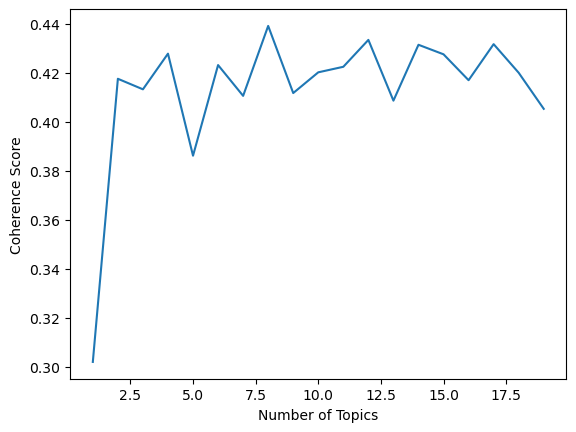

In [8]:
# compute coherence score using C_v to find opt number of topics.

topic = []
score = []

# to choose opt number of topics, I ran from 1 ~ 20 number of topics to compare coherence score.
# There are many ways to calculate coherence score, but I chose to go with the most genearlized one, which is c_v score.
# I put number of workers same as the number of cores for my device.
# I read few articles, and learned that c_v score of 0.5 is good.
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                        iterations=50, num_topics=i, workers=8, passes=50, random_state=100)
    cm = CoherenceModel(model=lda_model, texts=tokenized_docs,
                       corpus=doc_term_matrix, coherence='c_v')
    topic.append(i)
    score.append(cm.get_coherence())
    
plt.plot(topic, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

# As you can see, 8 shows the max c_v score but chose 7 instead because
# some topics overlap a lot mre if I choose 8. (visualized below)
# and choosing 7 still guarantees a descent coherence score.

In [9]:
# choosing 7 for my number of topics. Run the model with appropriate arguments.
# because this is the actual model, I increased the number of iterations and passes.
lda_model_opt = LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                        iterations=100, num_topics=7, workers=8, passes=100, random_state=100)

lda_model_opt.print_topics(-1)

[(0,
  '0.051*"container" + 0.038*"image" + 0.036*"linux" + 0.030*"docker" + 0.025*"install" + 0.023*"command" + 0.020*"containerd" + 0.019*"runtime" + 0.019*"binary" + 0.018*"expose"'),
 (1,
  '0.055*"cluster" + 0.031*"kubectl" + 0.030*"provider" + 0.029*"resource" + 0.026*"storage" + 0.024*"path" + 0.022*"pod" + 0.019*"volume" + 0.019*"name" + 0.016*"key"'),
 (2,
  '0.084*"metric" + 0.036*"prometheus" + 0.030*"default" + 0.026*"label" + 0.023*"value" + 0.020*"name" + 0.020*"collector" + 0.018*"server" + 0.018*"time" + 0.017*"java"'),
 (3,
  '0.064*"image" + 0.057*"container" + 0.046*"command" + 0.036*"chaos" + 0.034*"default" + 0.034*"docker" + 0.030*"target" + 0.029*"flag" + 0.026*"debug" + 0.022*"option"'),
 (4,
  '0.031*"service" + 0.026*"cluster" + 0.021*"network" + 0.018*"node" + 0.015*"mesh" + 0.015*"edge" + 0.013*"resource" + 0.012*"management" + 0.012*"deployment" + 0.011*"system"'),
 (5,
  '0.039*"policy" + 0.035*"meeting" + 0.031*"security" + 0.015*"join" + 0.013*"vulnerabi

In [18]:
# visualize our LDA model
# We can observe most relevant terms for each topic. I found it very useful.
# This visualization helped me to decide whether my model is good enough or not.
# I wanted the topics to be somewhat distinct (circles far from each other) and have similar sizes.
lda_display = pyLDAvis.gensim_models.prepare(lda_model_opt, doc_term_matrix, dictionary)
pyLDAvis.display(lda_display)

# 7 seemed like the best, so I chose to go with 7 instead of 8 number of topics.
# Weird thing to notice here is that the topic indices when they are printed (above)
# and when they are visualized (below) are different. The contents are the same, so
# I chose to go with the indices on actual data when they get printed out so that
# it makes it easier to assign topics to each repository.

# Another key point to make is that we can observe topic 6 and 7 having similar
# relevant terms. So I decided to merge these two topics together and make it a topic 6.

# so total of 6 topics to be classified.

In [11]:
# Just wanted to check out if each topics made sense for certain readme files
n = 12
print(lda_model_opt[doc_term_matrix][n])
print(readme_data['File'].tolist()[n])

[(6, 0.9968924)]
opentelemetry-java_README.md


In [15]:

# manually assign labels with top 10 words per topic based on my intuition
# notice that I combined topics 0 and 3 together and labeled them as Topic 0.
# Rest are labeled same as the topic index, skipping topic 3.
# This does not really matter because we only care about the labels not the indices.
topic_labels = {'Topic 0': 'Containerization and Docker Commands', 'Topic 1': 'Kubernetes Cluster Management and Resource Provisioning.',
                'Topic 2': 'Metric Monitoring and Prometheus Integration', 'Topic 4': 'Service and Cluster Management in Networking', 
                'Topic 5': 'Security Policies and Meetings', 'Topic 6': 'Management for DevOps'}

lda_model_opt.print_topics()
    

[(0,
  '0.051*"container" + 0.038*"image" + 0.036*"linux" + 0.030*"docker" + 0.025*"install" + 0.023*"command" + 0.020*"containerd" + 0.019*"runtime" + 0.019*"binary" + 0.018*"expose"'),
 (1,
  '0.055*"cluster" + 0.031*"kubectl" + 0.030*"provider" + 0.029*"resource" + 0.026*"storage" + 0.024*"path" + 0.022*"pod" + 0.019*"volume" + 0.019*"name" + 0.016*"key"'),
 (2,
  '0.084*"metric" + 0.036*"prometheus" + 0.030*"default" + 0.026*"label" + 0.023*"value" + 0.020*"name" + 0.020*"collector" + 0.018*"server" + 0.018*"time" + 0.017*"java"'),
 (3,
  '0.064*"image" + 0.057*"container" + 0.046*"command" + 0.036*"chaos" + 0.034*"default" + 0.034*"docker" + 0.030*"target" + 0.029*"flag" + 0.026*"debug" + 0.022*"option"'),
 (4,
  '0.031*"service" + 0.026*"cluster" + 0.021*"network" + 0.018*"node" + 0.015*"mesh" + 0.015*"edge" + 0.013*"resource" + 0.012*"management" + 0.012*"deployment" + 0.011*"system"'),
 (5,
  '0.039*"policy" + 0.035*"meeting" + 0.031*"security" + 0.015*"join" + 0.013*"vulnerabi

In [16]:
# assign topics for each repository and save output file
# For this assignment, I only considered the most probable topic for each repository.
# meaning that I assigned each repository into a topic with highest probability as suggested.
# For improvement, I could figure out a way to use the probability distribution across topics for each repository
# to figure out better classfication.

for i in range(len(lda_model_opt[doc_term_matrix])):
    topic_distribution = sorted(lda_model_opt[doc_term_matrix][i], key=lambda x: x[1], reverse=True)
    
    # combining topics 0 and 3
    if topic_distribution[0][0] == 3:
        temp = list(topic_distribution[0])
        temp[0] = 0
        topic_distribution[0] = tuple(temp)
    topic = topic_labels[f'Topic {topic_distribution[0][0]}']
    readme_data['Topics'][i] = topic

selected_columns = ['Repo', 'Topics']
selected_df = readme_data[selected_columns]

selected_df.to_csv('repository_topics.csv', index=False)

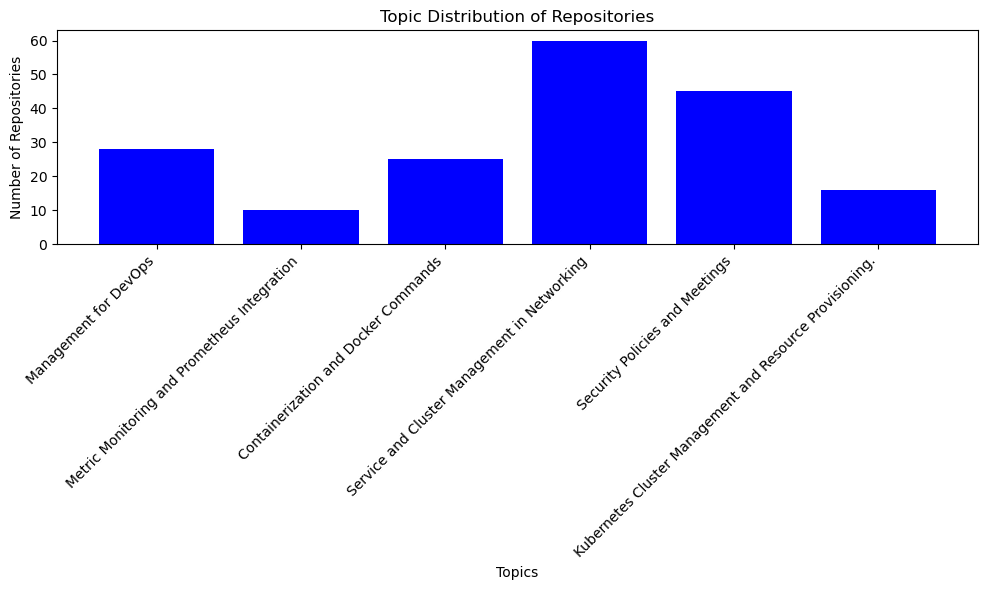

In [17]:
# visualize the distribution of repositories across topics

all_topics = [topic for topic in readme_data['Topics']]
topic_counts = Counter(all_topics)

topic_counts = pd.DataFrame.from_dict(topic_counts, orient='index', columns=['Number of Repositories'])

plt.figure(figsize=(10, 6))
plt.bar(topic_counts.index, topic_counts['Number of Repositories'], color='blue')
plt.xlabel('Topics')
plt.ylabel('Number of Repositories')
plt.title('Topic Distribution of Repositories')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()